In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime

In [2]:
df = pd.read_csv('training_data.csv')
df.head()

,filename,extension,size,created,modified,sensitive,read_only,executable
0,Scan_Image_477,docx,150843.92060,18-12-2024 08:50,25-02-2025 17:28,0,False,False
1,PAN_Document_9388,txt,300247.07700,05-07-2024 21:17,09-02-2025 00:50,1,True,False
2,Confidential_Cox PLC_Report,pdf,138472.65080,12-04-2023 02:53,12-02-2025 20:33,1,True,False
3,Ward_Bank_Statement_2025,txt,83991.05357,05-08-2023 18:52,11-02-2025 11:39,1,True,False
4,Scan_Image_699,pdf,175871.93680,05-06-2024 06:22,11-02-2025 06:52,0,False,False


In [3]:
df.isna().sum()

,0
filename,0
extension,0
size,0
created,0
modified,0
sensitive,0
read_only,0
executable,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    2000 non-null   object 
 1   extension   2000 non-null   object 
 2   size        2000 non-null   float64
 3   created     2000 non-null   object 
 4   modified    2000 non-null   object 
 5   sensitive   2000 non-null   int64  
 6   read_only   2000 non-null   bool   
 7   executable  2000 non-null   bool   
dtypes: bool(2), float64(1), int64(1), object(4)
memory usage: 97.8+ KB


In [5]:
df.describe()

,size,sensitive
count,2000.000000,2000.000000
mean,188275.033517,0.499500
std,102791.445839,0.500125
min,30928.627830,0.000000
25%,118187.040175,0.000000
50%,164181.041300,0.000000
75%,230982.541600,1.000000
max,889561.980000,1.000000


In [6]:

# Remove duplicates
df = df.drop_duplicates(subset=['filename', 'created'])

#  Validate datetime formats
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df['modified'] = pd.to_datetime(df['modified'], errors='coerce')

#  Fix inconsistent extensions
df['extension'] = df['extension'].str.lower().str.replace(' ', '')
df['extension'] = df['extension'].apply(lambda x: x if x in ['pdf','docx','xlsx','txt','jpg'] else 'other')
df.head()

<ipython-input-6-ced5cedffe16>:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['created'] = pd.to_datetime(df['created'], errors='coerce')
<ipython-input-6-ced5cedffe16>:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['modified'] = pd.to_datetime(df['modified'], errors='coerce')


,filename,extension,size,created,modified,sensitive,read_only,executable
0,Scan_Image_477,docx,150843.92060,2024-12-18 08:50:00,2025-02-25 17:28:00,0,False,False
1,PAN_Document_9388,txt,300247.07700,2024-07-05 21:17:00,2025-02-09 00:50:00,1,True,False
2,Confidential_Cox PLC_Report,pdf,138472.65080,2023-04-12 02:53:00,2025-02-12 20:33:00,1,True,False
3,Ward_Bank_Statement_2025,txt,83991.05357,2023-08-05 18:52:00,2025-02-11 11:39:00,1,True,False
4,Scan_Image_699,pdf,175871.93680,2024-06-05 06:22:00,2025-02-11 06:52:00,0,False,False


In [7]:
df['has_secret_keyword'] = df['filename'].str.contains(
    r'(?i)(?:^|[_-])(confidential|secret|private|aadhar|aadhaar|pan|salary|bank|account|ifsc|password|pin|credit|debit|ssn|passport|financial|income|tax|loan|transaction|insurance|agreement|contract|classified|office|official|employee|hr|budget|audit|payroll|statement|balance|investment)(?:[_-]|$)',
    regex=True
)

df.head()
df['has_secret_keyword'].value_counts()

<ipython-input-7-d6854e7de9fe>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_secret_keyword'] = df['filename'].str.contains(


,count
has_secret_keyword,
False,1219
True,781


In [9]:
#Feature Engineering

# Temporal features
current_date = datetime.now()
df['age_days'] = (current_date - df['created']).dt.days
df['modified_recency'] = (current_date - df['modified']).dt.days

#  Size categorization
size_bins = [0, 1024, 10240, 102400, 1048576]
size_labels = ['tiny', 'small', 'medium', 'large']
df['size_category'] = pd.cut(df['size'], bins=size_bins, labels=size_labels)

# Permission features
df['read_only'] = df['read_only'].astype(int)
df['executable'] = df['executable'].astype(int)

In [10]:
# File size outliers using IQR
Q1 = df['size'].quantile(0.25)
Q3 = df['size'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['size'] >= (Q1 - 1.5*IQR)) & (df['size'] <= (Q3 + 1.5*IQR))]


In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [12]:

#  Categorical encoding
cat_features = ['extension', 'size_category']
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#  Numeric scaling
num_features = ['age_days', 'modified_recency']
scaler = StandardScaler()

# Binary features
bin_features = ['has_secret_keyword', 'read_only', 'executable']

preprocessor = ColumnTransformer([
    ('cat', onehot, cat_features),
    ('num', scaler, num_features),
    ('bin', 'passthrough', bin_features)
])

In [26]:
import pickle

# Save the trained model
with open("preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file)

print("Model saved as preprocessor.pkl")


Model saved as preprocessor.pkl


In [14]:
from imblearn.over_sampling import SMOTE

X = preprocessor.fit_transform(df)
y = df['sensitive']

# Balance classes
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

Logistic Regression:
Accuracy: 0.8939
Precision: 1.0000
Recall: 0.7852
F1-Score: 0.8797
ROC AUC: 0.9387


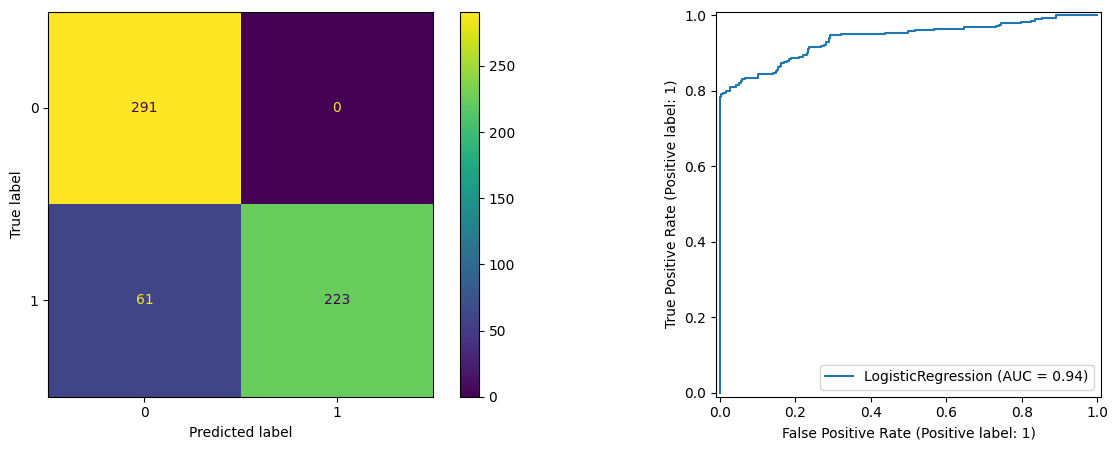

In [18]:
from sklearn.linear_model import LogisticRegression

# Train model
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

# Evaluate
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax2)
plt.show()

In [25]:
import pickle

# Save the trained model
with open("logistic_regression.pkl", "wb") as file:
    pickle.dump(lr, file)

print("Model saved as logistic_regression.pkl")


Model saved as logistic_regression.pkl



Support Vector Machine:
Accuracy: 0.8939
Precision: 1.0000
Recall: 0.7852
F1-Score: 0.8797
ROC AUC: 0.9249


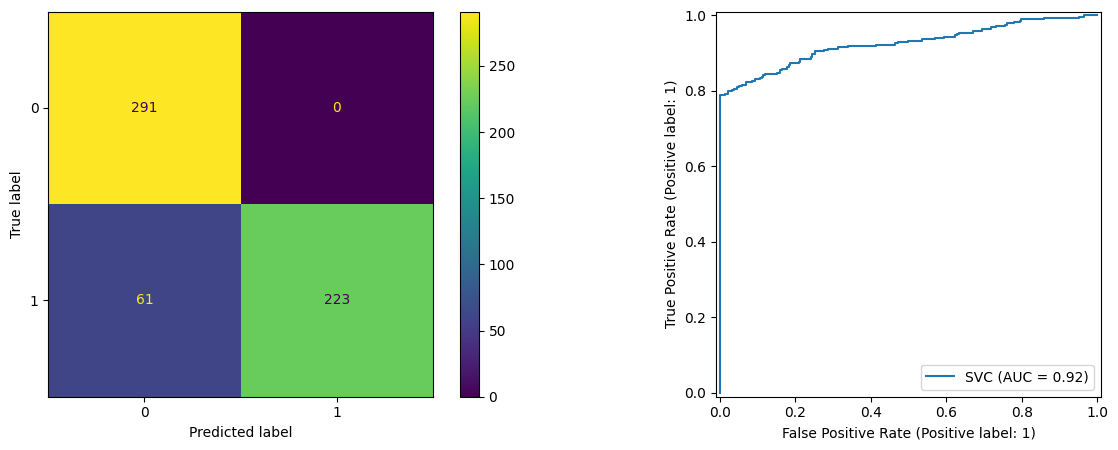

In [19]:
from sklearn.svm import SVC

# Train model
svm = SVC(class_weight='balanced', probability=True, kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

print("\nSupport Vector Machine:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(svm, X_test, y_test, ax=ax2)
plt.show()


Decision Tree:
Accuracy: 0.8800
Precision: 0.9574
Recall: 0.7923
F1-Score: 0.8671
ROC AUC: 0.9300


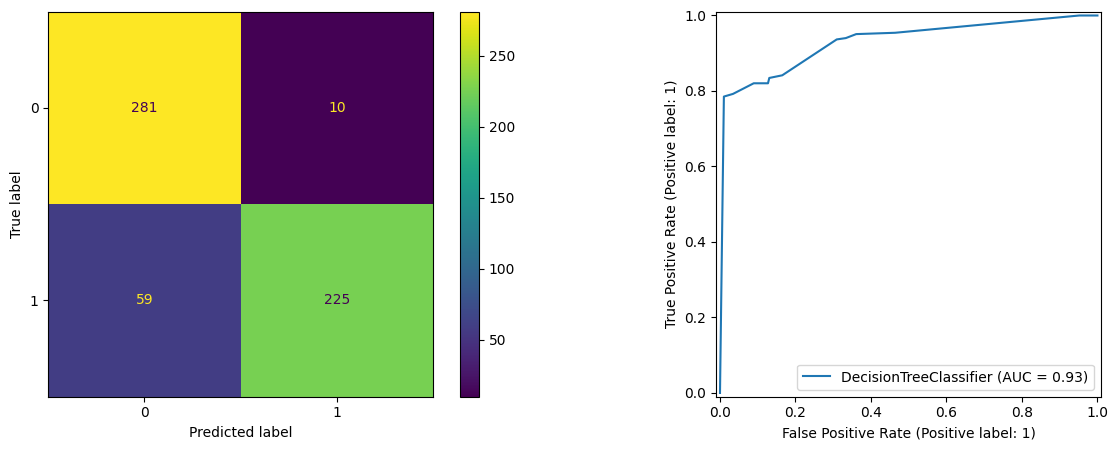

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Train model
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=5)
dt.fit(X_train, y_train)

# Evaluate
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]

print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(dt, X_test, y_test, ax=ax2)
plt.show()


Naive Bayes:
Accuracy: 0.8939
Precision: 1.0000
Recall: 0.7852
F1-Score: 0.8797
ROC AUC: 0.9340


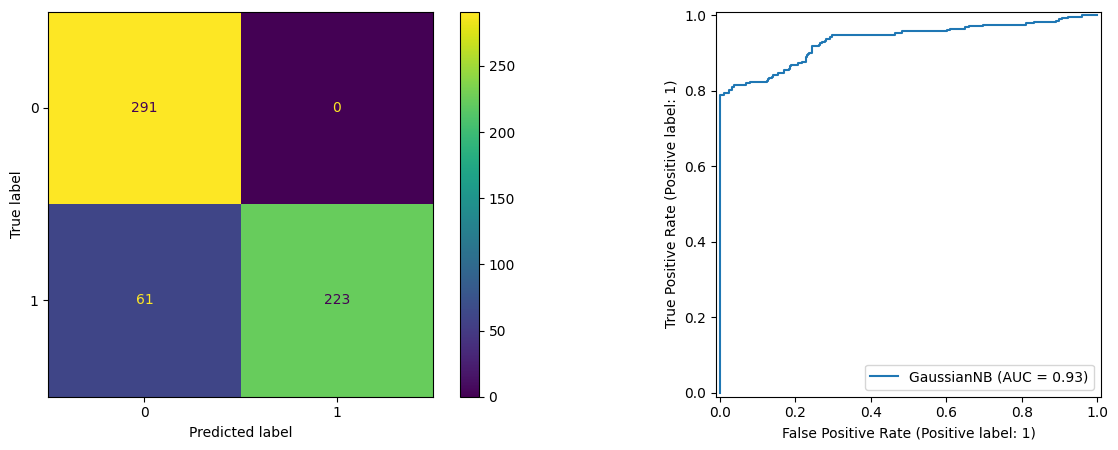

In [21]:
from sklearn.naive_bayes import GaussianNB

# Train model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate
y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)[:, 1]

print("\nNaive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(nb, X_test, y_test, ax=ax2)
plt.show()


K-Nearest Neighbors:
Accuracy: 0.8574
Precision: 0.9008
Recall: 0.7993
F1-Score: 0.8470
ROC AUC: 0.9129


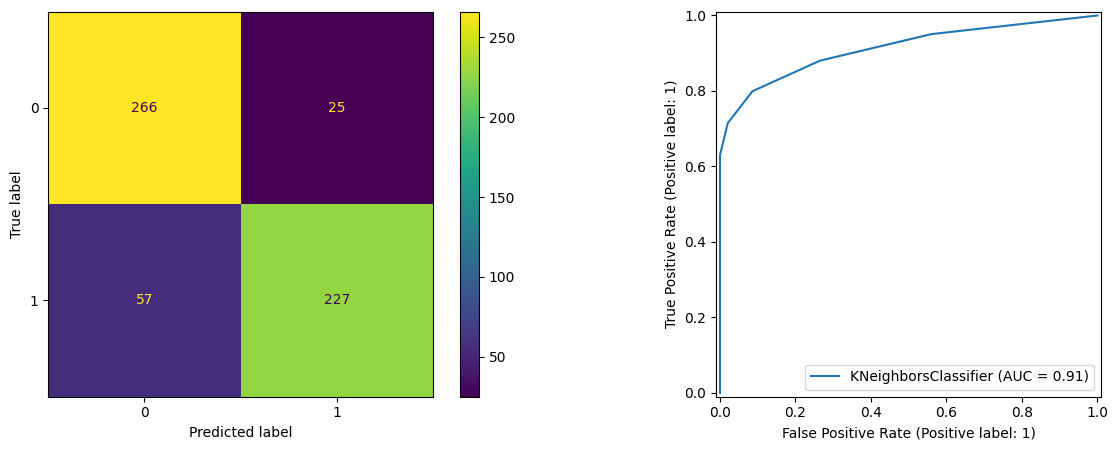

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Train model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

print("\nK-Nearest Neighbors:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax2)
plt.show()


Random Forest:
Accuracy: 0.8835
Precision: 0.9222
Recall: 0.8345
F1-Score: 0.8762
ROC AUC: 0.9288


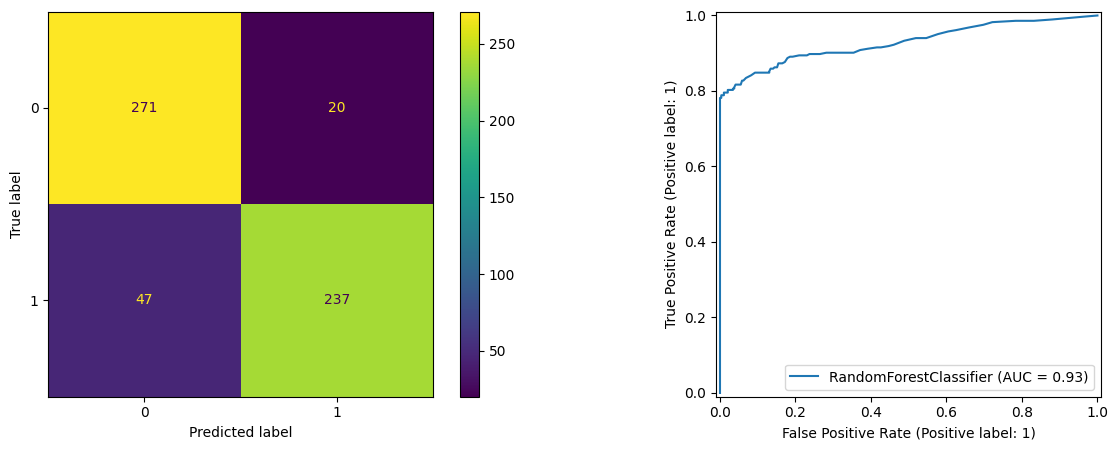

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax1)
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax2)
plt.show()